In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker 
import matplotlib.gridspec
import seaborn as sns

import pandas as pd
import pairtools
import bioframe

# Pairtools restrict walkthrough

The common approach to analyse Hi-C data is based to analyse the contacts of the restriction fragments. It is used in *hiclib*, Juicer, HiC-Pro. 

Throughout this notebook, we will work with one of [Rao et al. 2014 datasets for IMR90 cells](https://data.4dnucleome.org/experiment-set-replicates/4DNES1ZEJNRU/) [1]. 


[1] Rao, S. S., Huntley, M. H., Durand, N. C., Stamenova, E. K., Bochkov, I. D., Robinson, J. T., Sanborn, A. L., Machol, I., Omer, A. D., Lander, E. S., & Aiden, E. L. (2014). A 3D map of the human genome at kilobase resolution reveals principles of chromatin looping. Cell, 159(7), 1665–1680. https://doi.org/10.1016/j.cell.2014.11.021

### Download the data from 4DN portal

To download the data from 4DN, you may need to [register, get key and secret and write a spceialized curl command for your user](https://data.4dnucleome.org/help/user-guide/downloading-files): 

In [6]:
!curl -O -L --user QFYXHTWC:w6vwvhawzees3byl https://data.4dnucleome.org/files-processed/4DNFIW2BKSNF/@@download/4DNFIW2BKSNF.pairs.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   330  100   330    0     0   1289      0 --:--:-- --:--:-- --:--:--  1294
100 3395M  100 3395M    0     0  16.1M      0  0:03:30  0:03:30 --:--:-- 12.2M


In [ ]:
%%bash
# Get total number of contacts to assess how many reads you can read in the future:
pairtools stats 4DNFIW2BKSNF.pairs.gz | head -n 1
# This will produce around 173 M pairs

In [ ]:
%%bash
# Sample the fraction of pairs that will produce ~ 1 M of pairs:
pairtools sample 0.007 4DNFIW2BKSNF.pairs.gz -o 4DNFIW2BKSNF.pairs.sampled.gz

#### Annotate restriction fragments

In [ ]:
%%bash
# Digest the genome into restriction fragments.
# How to download the genome, follow general pairtools walkthrough:
# https://github.com/open2c/pairtools/blob/master/doc/examples/pairtools_walkthrough.ipynb

cooler digest ~/.local/share/genomes/hg38/hg38.fa.sizes ~/.local/share/genomes/hg38/hg38.fa MboI > hg38.MboI.restricted.bed

In [ ]:
%%bash
# Annotate restriction fragments in the sampled file: 
pairtools restrict -f hg38.MboI.restricted.bed 4DNFIW2BKSNF.pairs.sampled.gz -o 4DNFIW2BKSNF.pairs.sampled.restricted.gz

#### Read the pairs and analyse them as dataframe

In [3]:
from pairtools.lib import headerops, fileio

In [4]:
pairs_file = '4DNFIW2BKSNF.pairs.sampled.restricted.gz'

In [5]:
pairs_stream = fileio.auto_open(pairs_file, 'r')
header, pairs_stream = headerops.get_header(pairs_stream)
columns = headerops.get_colnames(header)

In [6]:
df = pd.read_table(pairs_stream, comment="#", header=None)
df.columns = columns

In [7]:
df.loc[:, 'dist_rfrag1_left'] = df.pos1 - df.rfrag_start1
df.loc[:, 'dist_rfrag1_right'] = df.rfrag_end1 - df.pos1

df.loc[:, 'dist_rfrag2_left'] = df.pos2 - df.rfrag_start2
df.loc[:, 'dist_rfrag2_right'] = df.rfrag_end2 - df.pos2

Many of the 5'-ends of reads are mapped to the restriction sites: 

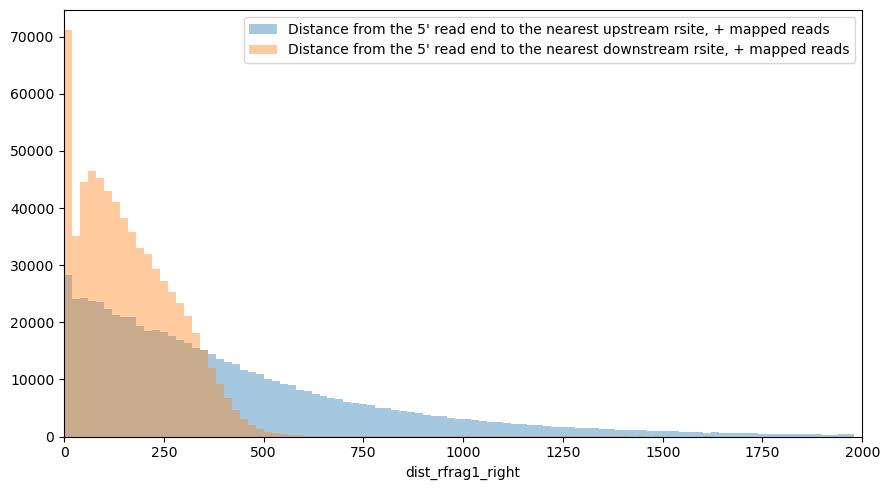

In [12]:
xmin = 0
xmax = 2000
step = 20

plt.figure(figsize=[9,5])
sns.distplot(df.query('strand1=="+"').dist_rfrag1_left, 
             bins=np.arange(xmin, xmax, step), 
             label='Distance from the 5\' read end to the nearest upstream rsite, + mapped reads',
             kde=False)
sns.distplot(df.query('strand1=="+"').dist_rfrag1_right, 
             bins=np.arange(xmin, xmax, step), 
             label='Distance from the 5\' read end to the nearest downstream rsite, + mapped reads', 
             kde=False)

plt.xlim(xmin, xmax)
plt.legend()
plt.tight_layout()

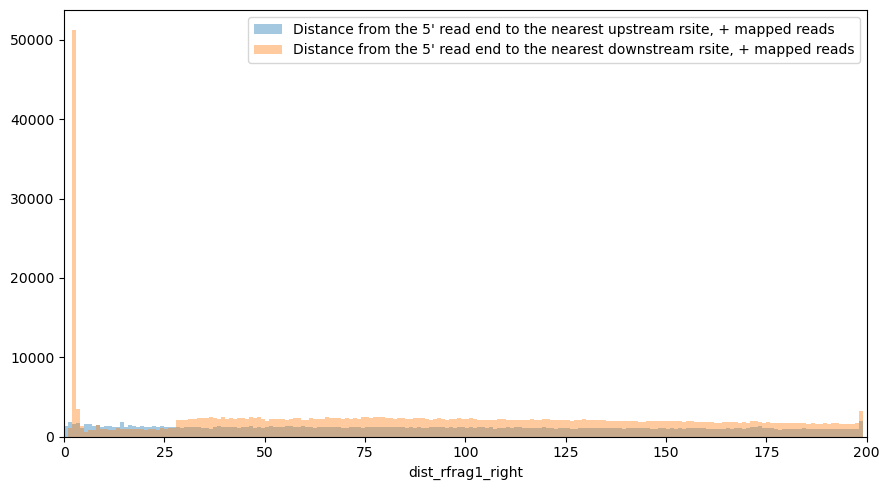

In [13]:
xmin = 0
xmax = 200
step = 1

plt.figure(figsize=[9,5])
sns.distplot(df.query('strand1=="+"').dist_rfrag1_left, 
             bins=np.arange(xmin, xmax, step), 
             label='Distance from the 5\' read end to the nearest upstream rsite, + mapped reads',
             kde=False)
sns.distplot(df.query('strand1=="+"').dist_rfrag1_right, 
             bins=np.arange(xmin, xmax, step), 
             label='Distance from the 5\' read end to the nearest downstream rsite, + mapped reads',
             kde=False)

plt.xlim(xmin, xmax)
plt.legend()
plt.tight_layout()

However, if we select only the pairs that map to the restriction sites, there is no significant skew in scaling:

In [14]:
hg38_chromsizes = bioframe.fetch_chromsizes('hg38', 
                                            as_bed=True)
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, 
                                    dict(hg38_cens.set_index('chrom').mid), 
                                    cols_chroms=('chrom', 'start', 'end') )

# To fix pandas bug in some versions: 
hg38_arms['start'] = hg38_arms['start'].astype(int)
hg38_arms['end'] = hg38_arms['end'].astype(int)

In [15]:
import pairtools.lib.scaling as scaling

In [16]:
def plot(cis_scalings, n, xlim=(1e1,1e9), label='' ):
    strand_gb = cis_scalings.groupby(['strand1', 'strand2'])
    for strands in ['+-', '-+', '++', '--']:
        sc_strand = strand_gb.get_group(tuple(strands))
        sc_agg = (sc_strand
            .groupby(['min_dist','max_dist'])
            .agg({'n_pairs':'sum', 'n_bp2':'sum'})
            .reset_index())

        dist_bin_mids = np.sqrt(sc_agg.min_dist * sc_agg.max_dist)
        pair_frequencies = sc_agg.n_pairs / sc_agg.n_bp2
        pair_frequencies = pair_frequencies/cis_scalings.n_pairs.sum()
        mask = pair_frequencies>0
        label_long = f'{strands[0]}{strands[1]} {label}'

        if np.sum(mask)>0:
            plt.loglog(
                dist_bin_mids[mask],
                pair_frequencies[mask],
                label=label_long,
                lw=2
            )

    plt.gca().xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0,numticks=20))
    plt.gca().yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0,numticks=20))
    plt.gca().set_aspect(1.0)
    plt.xlim(xlim)

    plt.grid(lw=0.5,color='gray')
    plt.legend(loc=(1.1,0.4))
    plt.ylabel('contact frequency, \nHi-C molecule per bp pair normalized by total')
    plt.xlabel('distance, bp')

    plt.tight_layout()

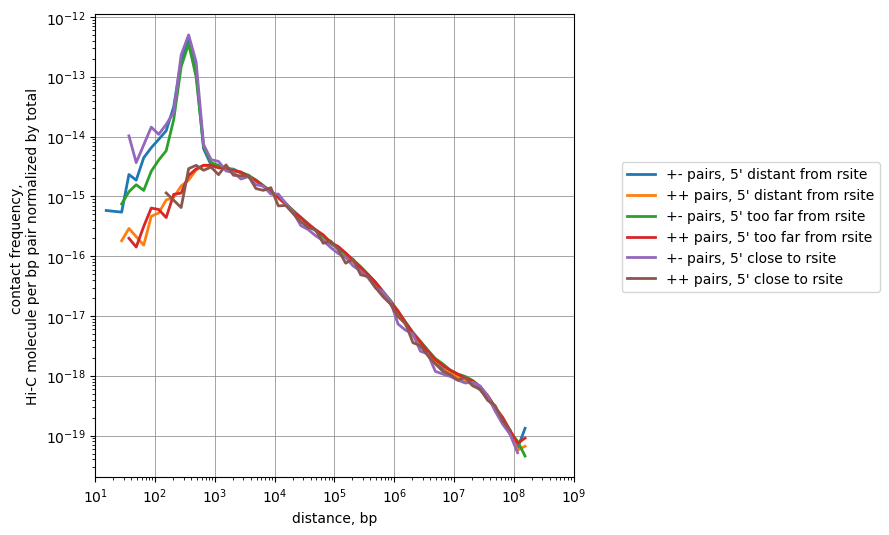

In [22]:
plt.figure(figsize=[9,9])

# Get the pairs where R1 is far enough from site of restriction, but not too far
df_subset = df.query("(strand1=='+' and dist_rfrag1_left>5 and dist_rfrag1_left<=250)")
n_distant = len(df_subset)
cis_scalings_distant, trans_levels_distant = scaling.compute_scaling(
                df_subset,
                regions=hg38_arms,
                chromsizes=hg38_arms,
                dist_range=(10, 1e9), 
                n_dist_bins_decade=8,
                chunksize=int(1e7),
            )
plot(cis_scalings_distant, n_distant, label="pairs, 5' distant from rsite")


# Get the pairs where R1 is too far enough from site of restriction
df_subset = df.query("(strand1=='+' and dist_rfrag1_left>550)")
n_toodistant = len(df_subset)
cis_scalings_toodistant, trans_levels_toodistant = scaling.compute_scaling(
                df_subset,
                regions=hg38_arms,
                chromsizes=hg38_arms,
                dist_range=(10, 1e9), 
                n_dist_bins_decade=8,
                chunksize=int(1e7),
            )
plot(cis_scalings_toodistant, n_toodistant, label="pairs, 5' too far from rsite")


# Get the pairs where R1 is very close to the site of restriction
df_subset = df.query("(strand1=='+' and dist_rfrag1_left<5)")
n_tooclose = len(df_subset)
cis_scalings_tooclose, trans_levels_tooclose = scaling.compute_scaling(
                df_subset,
                regions=hg38_arms,
                chromsizes=hg38_arms,
                dist_range=(10, 1e9), 
                n_dist_bins_decade=8,
                chunksize=int(1e7),
            )
plot(cis_scalings_tooclose, n_tooclose, label="pairs, 5' close to rsite")
# Try another replicate of replicate, maybe the last one 

#### How many pairs we take if not strictly filtering by dangling ends and self-circles? 

In [23]:
df.loc[:, "type_rfrag"] = "Regular pair"

mask_neighboring_rfrags = (np.abs(df.rfrag1-df.rfrag2)<=1)

mask_DE = (df.strand1=="+") & (df.strand2=="-") & mask_neighboring_rfrags
df.loc[mask_DE, "type_rfrag"] = "DanglingEnd"

mask_SS = (df.strand1=="-") & (df.strand2=="+") & mask_neighboring_rfrags
df.loc[mask_SS, "type_rfrag"] = "SelfCircle"

mask_Err = (df.strand1==df.strand2) & mask_neighboring_rfrags
df.loc[mask_Err, "type_rfrag"] = "Mirror"

In [24]:
df.sort_values("type_rfrag").groupby("type_rfrag").count()['readID']

type_rfrag
DanglingEnd       76703
Mirror             3225
Regular pair    1130730
SelfCircle         2953
Name: readID, dtype: int64

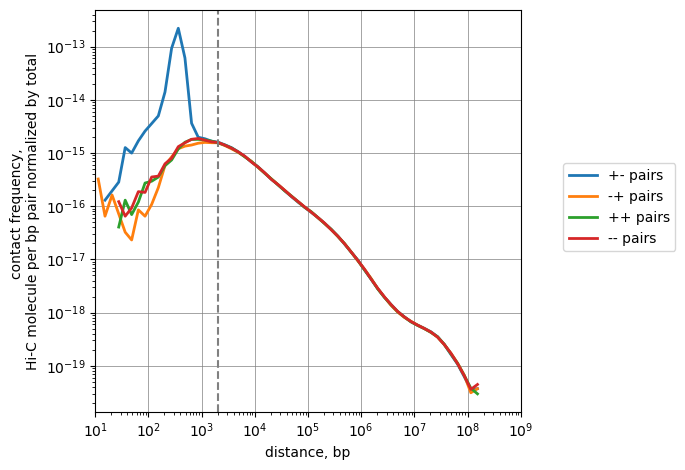

In [25]:
# Full scaling

n = len(df)
cis_scalings, trans_levels = scaling.compute_scaling(
                df,
                regions=hg38_arms,
                chromsizes=hg38_arms,
                dist_range=(10, 1e9), 
                n_dist_bins_decade=8,
                chunksize=int(1e7),
            )
plot(cis_scalings, n, label="pairs")

# The point where the scalings by distance become balanced:
plt.axvline(2e3, ls='--', c='gray', label='Balancing point')

plt.savefig("./oriented_scalings.pdf")

In [26]:
df.loc[:, "type_bydist"] = "Regular pair"

mask_ondiagonal = (np.abs(df.pos2-df.pos1)<=2e3)

mask_DE = (df.strand1=="+") & (df.strand2=="-") & mask_ondiagonal
df.loc[mask_DE, "type_bydist"] = "DanglingEnd"

mask_SS = (df.strand1=="-") & (df.strand2=="+") & mask_ondiagonal
df.loc[mask_SS, "type_bydist"] = "SelfCircle"

mask_Err = (df.strand1==df.strand2) & mask_ondiagonal
df.loc[mask_Err, "type_bydist"] = "Mirror"

In [27]:
df.sort_values("type_bydist").groupby("type_bydist").count()['readID']

type_bydist
DanglingEnd      134541
Mirror            18218
Regular pair    1052562
SelfCircle         8290
Name: readID, dtype: int64

In [28]:
df.sort_values(["type_rfrag", "type_bydist"])\
    .groupby(["type_rfrag", "type_bydist"])\
    .count()[['readID']]\
    .reset_index()\
    .pivot(columns="type_bydist", index="type_rfrag")\
    .fillna(0).astype(int)

readID                               
type_bydist  DanglingEnd Mirror Regular pair SelfCircle
type_rfrag                                             
DanglingEnd        76703      0            0          0
Mirror                 0   3163           62          0
Regular pair       57838  15055      1052356       5481
SelfCircle             0      0          144       2809

False Positives are in 3rd row, False Negatives are in 3rd column. Filtering by distance is, thus, nearly as effective as filtering by restriction fragment, but removes additional pairs that can be potential undercut by restriction enzyme.

Removing all contacts closer than 2 Kb will remove Hi-C artifacts.